In [2]:
"""
Author: Davy Neven
Licensed under the CC BY-NC 4.0 license (https://creativecommons.org/licenses/by-nc/4.0/)
"""
import os
import time

import torchvision
from matplotlib import pyplot as plt
from tqdm import tqdm

import train_config  # for CVPPP
import torch
from datasets import get_dataset
from models import get_model
from utils.utils_cvppp import Cluster, Visualizer  # for CVPPP
import numpy as np
from PIL import Image
from torchvision.utils import save_image

torch.backends.cudnn.benchmark = True

args = train_config.get_args()

args['train_dataset']['name'] = 'Corn'
args['train_dataset']['kwargs']['root_dir'] = 'C:/Users/iml/Desktop/ERFNet_ClassSegV3/Datas/corn'
args['val_dataset']['name'] = 'Corn'
args['val_dataset']['kwargs']['root_dir'] = 'C:/Users/iml/Desktop/ERFNet_ClassSegV3/Datas/corn'

args['model']['name'] = 'ERFNet_Semantic_Embedding1_4'
args['checkpoint_path'] = 'D:/EmbeddingBasedSeg/Corn/Semantic_Embedding1_4/cosine_intra/dim=32/weight/best_recon2_iou_model_289.pth'

# set device
device = torch.device("cuda:0" if args['cuda'] else "cpu")

# train dataloader
train_dataset = get_dataset(
    args['train_dataset']['name'], args['train_dataset']['kwargs'])
train_dataset_it = torch.utils.data.DataLoader(
    train_dataset, batch_size=args['train_dataset']['batch_size'], shuffle=True, drop_last=True,
    num_workers=args['train_dataset']['workers'], pin_memory=True if args['cuda'] else False)

# val dataloader
val_dataset = get_dataset(
    args['val_dataset']['name'], args['val_dataset']['kwargs'])
val_dataset_it = torch.utils.data.DataLoader(
    val_dataset, batch_size=args['val_dataset']['batch_size'], shuffle=False, drop_last=True,
    num_workers=args['train_dataset']['workers'], pin_memory=True if args['cuda'] else False)

# load model
model = get_model(args['model']['name'], args['model']['kwargs'])
model = torch.nn.DataParallel(model).to(device)

state = torch.load(args['checkpoint_path'])
model.load_state_dict(state['model_state_dict'], strict=True)
model.eval()

# image files:  81
# label_all files:  81
Corn dataset created [train2]
# image files:  10
# label_all files:  10
Corn dataset created [val2]
Creating Branched ERFNet_Semantic_Embedding1_4 with 3 classes


DataParallel(
  (module): ERFNet_Semantic_Embedding1_4(
    (encoder): Encoder(
      (initial_block): DownsamplerBlock(
        (conv): Conv2d(3, 13, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (layers1): ModuleList(
        (0): DownsamplerBlock(
          (conv): Conv2d(16, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): non_bottleneck_1d(
          (conv3x1_1): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
          (conv1x3_1): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
          (bn1): BatchNorm2d(64, eps=0.001, momentum

In [3]:
from sklearn.decomposition import PCA
import cv2
import matplotlib.pyplot as plt

def visulizeFeatureMapPCA(feature):
    feature = feature.squeeze().data.cpu().numpy()
    # img_out = np.mean(feature, axis=0)
    c, h, w = feature.shape
    img_out = feature.reshape(c, -1).transpose(1, 0)
    pca = PCA(n_components=3)
    pca.fit(img_out)
    img_out_pca = pca.transform(img_out)
    img_out_pca = img_out_pca.transpose(1, 0).reshape(3, h, w).transpose(1, 2, 0)

    cv2.normalize(img_out_pca, img_out_pca, 0, 255, cv2.NORM_MINMAX)
    img_out_pca = cv2.resize(img_out_pca, (h, w),interpolation=cv2.INTER_LINEAR)
    img_out = np.array(img_out_pca, dtype=np.uint8)

    return img_out

In [4]:
def calculate_iou(pred, label):
    intersection = ((label == 1) & (pred == 1)).sum()
    union = ((label == 1) | (pred == 1)).sum()
    if not union:
        return 0
    else:
        iou = intersection.item() / union.item()
        return iou

In [12]:
result_plant = []
result_disease = []

embs = []
preds = []
gts = []

for iteration, sample in enumerate(val_dataset_it):

    im = sample['image']  # (N, 3, 512, 512)
    instances_plant = sample['instance_plant'].squeeze()
    instances_disease = sample['instance_disease'].squeeze()
    class_label = sample['instance_all'].squeeze()
    gts.append(class_label)
    
    # embedding: (N, 32, 512, 512)
    # output: (N, 3, 512, 512)
    #embedding, output = model(im)
    embedding, pred = model(im) 
    embs.append(embedding)
    
    pred = pred.cpu().detach().max(dim=1)[1]
    preds.append(pred)

    pred_plant = (pred == 1)
    pred_disease = (pred == 2)

    gt_plant = (class_label[0].unsqueeze(0) == 1)
    gt_disease = (class_label[0].unsqueeze(0) == 2)
    
    plant_iou = calculate_iou(pred_plant, instances_plant)
    disease_iou = calculate_iou(pred_disease, instances_disease)
    
    result_plant.append(plant_iou)
    result_disease.append(disease_iou)
    
print('plant iou :', sum(result_plant) / len(result_plant))
print('disease iou :', sum(result_disease) / len(result_disease))

plant iou : 0.8089579655088329
disease iou : 0.4366765093811121


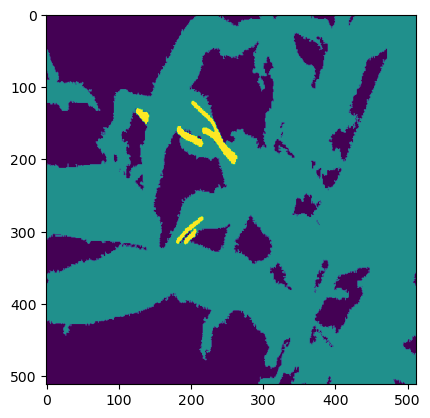

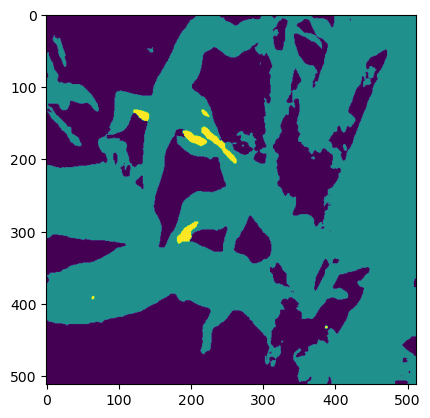

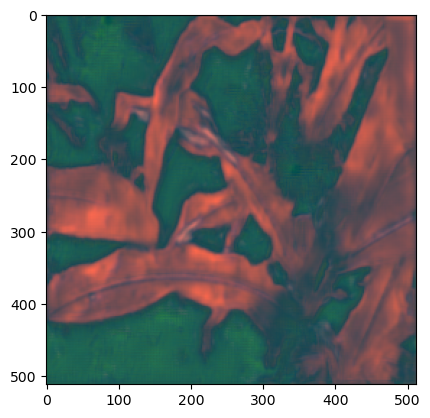

In [37]:
b = 4  # -1, 4

plt.imshow(gts[b])
plt.show()
plt.imshow(preds[b][0])
plt.show()
plt.imshow(visulizeFeatureMapPCA(embs[b]))
plt.show()